In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import sklearn

import fasttext
import re
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

In [2]:
from content_based_model import ContentBasedRecommender
from evaluator import ModelEvaluator

In [3]:
articles = pd.read_csv('./data/articles_clean.csv')
articles_lemma = pd.read_csv('./data/articles_lemmatized.csv')

## Wektoryzacja

In [4]:
stopwords_list = stopwords.words('german') # are there other languages in text

### TFIDF

In [5]:

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 3), # bi - gram (?)
                     min_df=0.01,
                     max_df=0.7,
                     max_features=5000,
                     stop_words=stopwords_list)


### User profiles (?)

In [6]:
readers = pd.read_csv('./../readers.csv')

In [8]:
# all users have enough interactions (min 5) so train-test-split basically on readers dataset
interactions_train, interactions_test = train_test_split(readers,
                                   stratify=readers['id'], 
                                   test_size=0.20,
                                   random_state=123)

print('# interactions on Train set: %d' % len(interactions_train))
print('# interactions on Test set: %d' % len(interactions_test))

# interactions on Train set: 22284
# interactions on Test set: 5571


In [9]:
def vectorize_and_build_profiles(vectorizer,data):

    def vectorize(vectorizer, data):
        matrix  = vectorizer.fit_transform(data)
        feature_names = vectorizer.get_feature_names()
        return matrix, feature_names

    def get_one_article_profile(item_id: str, matrix):
        idx = articles['nzz_id'].tolist().index(item_id)
        item_profile = matrix[idx:idx+1]
        return item_profile

    def get_articles_profiles(ids,matrix):
        item_profiles_list = [get_one_article_profile(x,matrix) for x in ids]
        item_profiles = scipy.sparse.vstack(item_profiles_list)
        return item_profiles

    def build_users_profiles(matrix): 
        interactions = interactions_train[interactions_train['art_id'].isin(articles['nzz_id'])].set_index('id')
        user_profiles = {}
        for person_id in interactions.index.unique():
            user_item_profiles = get_articles_profiles(interactions.loc[person_id,'art_id'],matrix)
            user_profiles[person_id] = sklearn.preprocessing.normalize(np.sum(user_item_profiles, axis=0))
        return user_profiles
    
    matrix, features = vectorize(vectorizer, data)
    user_profiles = build_users_profiles(matrix)
    return matrix, features, user_profiles

In [10]:
matrix, feat_names, user_profiles = vectorize_and_build_profiles(tfidf_vectorizer, articles['content'])

### Articles similarity

In [11]:
content_based_recommender_model = ContentBasedRecommender(readers, articles, user_profiles, matrix)
model_evaluator = ModelEvaluator()  

In [27]:
recs = content_based_recommender_model.recommend_items(200)

In [28]:
def filter_similar_recs(user_recs, matrix, similarity_level):
    
    id_list = list(user_recs['art_id'])
    indices = articles[articles.nzz_id.isin(id_list)].index.tolist()

    cosine_sim_matrix = cosine_similarity(matrix[indices])
    matrix_lower = np.tril(cosine_similarity(matrix[indices]))
    np.fill_diagonal(matrix_lower, 0)
    similar_pairs = np.where(matrix_lower>=similarity_level)
    similar_df = pd.DataFrame(np.column_stack(similar_pairs),columns=['first_art','second_art'])

    new_indices = [x for i, x in enumerate(indices) if i not in list(similar_df['first_art'])]
    filtered_recs_ind = articles.loc[new_indices, 'nzz_id']

    new_recs = user_recs.loc[user_recs.art_id.isin(list(filtered_recs_ind))]

    return new_recs

In [31]:
filter_similar_recs(recs, matrix, 0.4)

,art_id,recStrength
0,ld.137099,0.419695
3,ld.141928,0.381344
4,ld.137751,0.378720
5,ld.147428,0.374231
6,ld.143038,0.373578
7,ld.147213,0.368438
8,ld.141993,0.364303
9,ld.141346,0.363449


In [26]:
#########################################
#########################################
#########################################

In [21]:
def  get_read_articles(person_id):
        # Get the user's data and merge in the article info
    interacted_items = readers.loc[person_id, 'art_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])
        

In [18]:
def get_recs_for_user(user_id):
    for i in range(len(people_recs)):
        if people_recs[i].loc[1,'_person_id'] == user_id:
            return people_recs[i]

In [19]:
recs = get_recs_for_user(411)
recs

,art_id,recStrength,_person_id
0,ld.138364,0.458265,411
1,ld.139822,0.419848,411
2,ld.139143,0.409991,411
3,ld.141102,0.404845,411
4,ld.140381,0.400806,411
...,...,...,...
977,ld.141173,0.248292,411
978,ld.142119,0.248191,411
979,ld.145887,0.248153,411
980,ld.151375,0.248139,411


In [17]:
cb_global_metrics, cb_detailed_results_df, people_recs = model_evaluator.evaluate_model(content_based_recommender_model, articles, readers, interactions_train, interactions_test)

999 users processed


In [20]:
list(recs['art_id'])[1]

'ld.139822'

In [75]:
list_for_test = list(recs['art_id'])[20:30]
list_for_test

['ld.144162',
 'ld.142639',
 'ld.140834',
 'ld.143546',
 'ld.140200',
 'ld.147480',
 'ld.138165',
 'ld.1289252',
 'ld.146048',
 'ld.139216']

In [76]:
list_full = list(recs['art_id'])

In [96]:
indices = articles[articles.nzz_id.isin(list_for_test)].index.tolist()
indices_full = articles[articles.nzz_id.isin(list_full)].index.tolist()

In [78]:
pd.DataFrame(cosine_similarity(tfidf_matrix[indices_full]))

,0,1,2,3,4,5,6,7,8,9,...,972,973,974,975,976,977,978,979,980,981
0,1.000000,0.137855,0.566121,0.091091,0.034822,0.186635,0.061657,0.298902,0.078255,0.266386,...,0.084415,0.306630,0.053428,0.421129,0.238868,0.087352,0.228281,0.146367,0.199889,0.335671
1,0.137855,1.000000,0.182852,0.186177,0.120673,0.280902,0.139153,0.097486,0.082015,0.071599,...,0.092459,0.121550,0.110281,0.190159,0.096952,0.098723,0.103854,0.163082,0.124230,0.141847
2,0.566121,0.182852,1.000000,0.189666,0.088180,0.242287,0.077818,0.258094,0.051746,0.250914,...,0.048918,0.406740,0.051198,0.428183,0.193468,0.154602,0.271361,0.113753,0.261994,0.376439
3,0.091091,0.186177,0.189666,1.000000,0.091949,0.124010,0.082631,0.124485,0.102547,0.119076,...,0.098436,0.217404,0.105885,0.127166,0.200645,0.141616,0.152868,0.126718,0.181128,0.217983
4,0.034822,0.120673,0.088180,0.091949,1.000000,0.150879,0.272595,0.059825,0.108725,0.099855,...,0.110505,0.119193,0.163684,0.003861,0.133828,0.144758,0.049612,0.091131,0.046018,0.051900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,0.087352,0.098723,0.154602,0.141616,0.144758,0.117861,0.112024,0.072614,0.124272,0.096680,...,0.159841,0.115740,0.133542,0.038926,0.174106,1.000000,0.157464,0.119454,0.205003,0.116103
978,0.228281,0.103854,0.271361,0.152868,0.049612,0.210126,0.072093,0.124720,0.103169,0.115435,...,0.100416,0.256679,0.114863,0.244893,0.168685,0.157464,1.000000,0.195728,0.326188,0.255393
979,0.146367,0.163082,0.113753,0.126718,0.091131,0.275090,0.114476,0.093160,0.193388,0.106268,...,0.159370,0.176954,0.152064,0.100849,0.120557,0.119454,0.195728,1.000000,0.077189,0.111102
980,0.199889,0.124230,0.261994,0.181128,0.046018,0.164105,0.039548,0.130494,0.077534,0.107035,...,0.113734,0.290059,0.056314,0.240593,0.107899,0.205003,0.326188,0.077189,1.000000,0.242667


In [90]:
indices

[1631, 3429, 8513, 9497, 10434, 13531, 14011, 17384, 19473, 21106]

In [79]:
import seaborn as sns

C:\Users\a814810\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='80'>

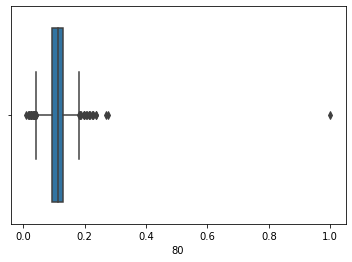

In [80]:
sns.boxplot(pd.DataFrame(cosine_similarity(tfidf_matrix[indices_full]))[80])

In [81]:
cosine_similarity(tfidf_matrix[indices])

array([[1.        , 0.16317732, 0.04994533, 0.09301666, 0.07686079,
        0.07566958, 0.07816969, 0.05854491, 0.11324772, 0.05921552],
       [0.16317732, 1.        , 0.40160586, 0.25788055, 0.32489819,
        0.37044208, 0.30382447, 0.27895077, 0.25732862, 0.37133238],
       [0.04994533, 0.40160586, 1.        , 0.25256537, 0.51376766,
        0.53866993, 0.41051145, 0.39641514, 0.25764665, 0.56609313],
       [0.09301666, 0.25788055, 0.25256537, 1.        , 0.25517619,
        0.26846252, 0.37938733, 0.19211244, 0.15529447, 0.24424773],
       [0.07686079, 0.32489819, 0.51376766, 0.25517619, 1.        ,
        0.49903874, 0.39937188, 0.30898422, 0.22481968, 0.44684299],
       [0.07566958, 0.37044208, 0.53866993, 0.26846252, 0.49903874,
        1.        , 0.4538862 , 0.33622574, 0.18209755, 0.49600925],
       [0.07816969, 0.30382447, 0.41051145, 0.37938733, 0.39937188,
        0.4538862 , 1.        , 0.23393911, 0.20992728, 0.39438952],
       [0.05854491, 0.27895077, 0.3964151

In [82]:
np.mean(pd.DataFrame(cosine_similarity(tfidf_matrix[indices_full])).describe(), axis=1)

count    982.000000
mean       0.136259
std        0.088651
min        0.006644
25%        0.069576
50%        0.117573
75%        0.188088
max        1.000000
dtype: float64

In [83]:
matrix_lower = np.tril(cosine_similarity(tfidf_matrix[indices]))
np.fill_diagonal(matrix_lower, 0)

In [84]:
matrix_lower

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16317732, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.04994533, 0.40160586, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.09301666, 0.25788055, 0.25256537, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.07686079, 0.32489819, 0.51376766, 0.25517619, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.07566958, 0.37044208, 0.53866993, 0.26846252, 0.49903874,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.07816969, 0.30382447, 0.41051145, 0.37938733, 0.39937188,
        0.4538862 , 0.        , 0.        , 0.        , 0.        ],
       [0.05854491, 0.27895077, 0.3964151

In [87]:
np.where(matrix_lower>0.4)

(array([2, 4, 5, 5, 6, 6, 9, 9, 9], dtype=int64),
 array([1, 2, 2, 4, 2, 5, 2, 4, 5], dtype=int64))

In [89]:
similar = pd.DataFrame(np.column_stack(np.where(matrix_lower>0.4)),columns=['first_art','second_art'])

In [95]:
similar.first_art

0    2
1    4
2    5
3    5
4    6
5    6
6    9
7    9
8    9
Name: first_art, dtype: int64

In [99]:
indices = [x for i, x in enumerate(indices) if i not in list(similar['first_art'])]

In [100]:
indices

[1631, 3429, 9497, 17384, 19473]

In [102]:
filtered_recs_ind = articles.loc[indices, 'nzz_id']

In [103]:
filtered_recs_ind

1631     ld.144162
3429     ld.142639
9497     ld.140834
17384    ld.143546
19473    ld.146048
Name: nzz_id, dtype: object

In [105]:
recs_test = recs.loc[recs.art_id.isin(list(filtered_recs_ind))]

In [106]:
recs_test

,art_id,recStrength,_person_id
20,ld.144162,0.356907,411
21,ld.142639,0.356454,411
22,ld.140834,0.355414,411
23,ld.143546,0.355264,411
28,ld.146048,0.352580,411


In [115]:
filter_similar_recs(411, tfidf_matrix, 0.6)

,art_id,recStrength,_person_id
0,ld.138364,0.458265,411
1,ld.139822,0.419848,411
4,ld.140381,0.400806,411
5,ld.141993,0.394523,411
6,ld.146206,0.381396,411
...,...,...,...
977,ld.141173,0.248292,411
978,ld.142119,0.248191,411
979,ld.145887,0.248153,411
980,ld.151375,0.248139,411


In [111]:
get_recs_for_user(411)

,art_id,recStrength,_person_id
0,ld.138364,0.458265,411
1,ld.139822,0.419848,411
2,ld.139143,0.409991,411
3,ld.141102,0.404845,411
4,ld.140381,0.400806,411
...,...,...,...
977,ld.141173,0.248292,411
978,ld.142119,0.248191,411
979,ld.145887,0.248153,411
980,ld.151375,0.248139,411


In [27]:
print('Evaluating Content-Based Filtering model...')
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.11236761802189912, 'recall@10': 0.12475318614252379}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
358,2,2,10,0.2,0.2,907
721,1,1,10,0.1,0.1,938
510,2,2,10,0.2,0.2,64
86,2,2,10,0.2,0.2,887
484,2,2,10,0.2,0.2,397
472,2,2,10,0.2,0.2,218
259,2,3,10,0.2,0.3,273
264,0,0,10,0.0,0.0,803
797,2,2,10,0.2,0.2,865
276,2,2,10,0.2,0.2,443
